In [4]:
#导入一些必要的包
import os
import random
import paddle 
from paddle import nn
from paddle import optimizer as optim 
from paddle import fluid

#import paddle.vision.datasets as dset
#import paddle.vision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation 

from tqdm import tqdm
from util.model import GeluSigGenerator,GeluSigGenerator,Generator,GeluGenerator,Generator256,SELUGenerator,HybridGenerator,NewHybridGenerator

import matplotlib.pyplot as plt

from util.config import BATCH_SIZE, INPUT_SIZE, MAX_VAL
OUTPUT_SIZE = 256
#将numpy拉展为list
def flatten(irregular_matrix) -> list:
    """ Allows flattening a matrix of nested iterables where the specific type
        and shape of each iterable is not necessarily the same. Returns
        the individual elements of the original nested iterable in a single
        flat list.

        Note that this operation's implementation is rather slow, and should
        be avoided unless necessary.

        :param irregular_matrix: a nested iterable with irregular dimensions
    """
    flattened_list = []
    try:
        for element in irregular_matrix:
            flattened_list.extend(flatten(element))
        return flattened_list
    except TypeError:
        return irregular_matrix

#将整数写入文件filename中，以8 asscii的格式
def write_numbers_to_ascii_file(values, filename: str):
    """ Produces an ASCII output text file containing hexadecimal representations
        of each number produces by the generator.

        :param values: list or numpy array values produced by generator
        :param filename: name of file to write output into
    """
    # create directory structure to file if not exists
    if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
    # flatten and encode in hex
    values = flatten(values)
    values = [format(np.uint8(i), 'x') for i in values]
    # write hex values to ASCII file
    with open(filename, 'w+') as file:
        for hex_val in tqdm(values, 'Writing to file ... '):
            file.write(str(hex_val) + "\n")


#将filename中的asscii格式，转化为16位的二进制格式;一个文件对一个文件转化
def write_ascii_to_bin_file(filename):
    new_filename = filename[:-4] + '_dieharder.txt'
    # for each file, open and create edited
    with open(filename) as file, open(new_filename, 'w') as new_file:
        data = file.readlines()
        for number in data:
            new_file.write(format(int(number,16), '08b'))

#将filenames为list类型，将多个finame转化为一个二进制文件，注意是多个对一个
def mul_write_ascii_to_bin_file(filenames,new_filename):
    with open(new_filename,'a+') as new_file:
        for filename in filenames:
        # for each file, open and create edited
            with open(filename) as file:
                data = file.readlines()
                for number in data:
                    new_file.write(format(int(number, 16), '08b'))


def reference_distribution_np(batch_size, seq_length, max_val) -> np.ndarray:
    """ Returns a batch of inputs sampled from the reference distribution, i.e.
    from the random uniform distribution. """
    return np.random.uniform(size=[batch_size, seq_length], low=0, high=max_val)


# 定义一个函数将float转化为8位二进制序列
def int_to_bin(x):
    # 检查x是否在0到255之间
    if x < 0 or x > 255:
        raise ValueError("x must be between 0 and 255")
    # 将x四舍五入为整数
    #x_int = round(x)
    # 将x_int转化为二进制字符串，并去掉前缀"0b"
    bin_str = bin(x)[2:]
    # 在左边补足0，使长度为8
    bin_str = bin_str.zfill(8)
    # 返回二进制字符串
    return bin_str

def get_rand_from_mantissa(manti):
    #从尾数中获取从小数点后第二位开始的3位数字。如果不够3位，则补0
    t_str = str(manti).split('.')[1][4:7]
    length = len(t_str)
    if length <3:
        for i in range(3-length):
            t_str = ''.join([t_str,'0'])

    return int(t_str)%256



#产生从0到max_val的随机数，类型为paddle.Tensor,大小为[batch_size, seq_length]，其中floor为向下取整
def reference_distribution_paddle(batch_size, seq_length, max_val) -> paddle.Tensor:
    #return fluid.layers.uniform_random(shape=[batch_size, seq_length], min=-0.5*max_val, max=0.5*max_val).floor()
    return fluid.layers.uniform_random(shape=[batch_size, seq_length], min=0., max=max_val).floor()

# 定义一个函数将float转化为8位二进制序列
def float_to_bin(x):
    # 检查x是否在0到255之间
    if x < 0 or x > 255:
        raise ValueError("x must be between 0 and 255")
    # 将x四舍五入为整数
    x_int = round(x)
    # 将x_int转化为二进制字符串，并去掉前缀"0b"
    bin_str = bin(x_int)[2:]
    # 在左边补足0，使长度为8
    bin_str = bin_str.zfill(8)
    # 返回二进制字符串
    return bin_str

#将双精度的浮点数，转换为二进制表示，通常有23位
def decimal_to_binary(a, n=16,j=0,k=8):
    b = np.zeros(n+1, dtype=int)
    for i in range(1, n+1, 1):
        x = 2**(-1*i)
        if (a - x) >= 0:
            b[i] = 1
            a -= x
    b = b[1::]
    x = [str(i) for i in b]
    b_str = "".join(x)

    return b_str[j:k]

# 定义一个函数将二进制序列转化为字符串，不分隔每个元素
def bin_to_str(x):
    # 将数组转化为列表
    x_list = x.tolist()
    # 用空格连接列表中的每个元素
    x_str = "".join(x_list)
    # 返回字符串
    return x_str

def write_bin_str(bin_arr, filename):
    bin_arr = bin_arr.flatten()

    # 使用函数将二进制序列转化为字符串
    bin_str = bin_to_str(bin_arr)

    # 打开一个txt文件，如果不存在则创建一个
    with open(filename,'w') as f:
        f.write(bin_str)

# 定义一个函数将两个数组水平相接
def h_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第i行第j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第i行第j+n列位置
            result[ i, j + n] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组垂直相接
def v_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m * 2, n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第i行第j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第i行第j+n列位置
            result[ m + i, j] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组交叉相接
def cross_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第2i行第2j列位置
            result[i, 2 * j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第2i行第2j+1列位置
            result[ i, 2 * j + 1] = arr2[i, j]
    # 返回结果数组
    return result


# 定义一个函数将两个数组交叉相接
def reverse_join(arr1, arr2):
    # 检查两个数组是否有相同的形状
    if arr1.shape != arr2.shape:
        raise ValueError("arr1 and arr2 must have the same shape")
    # 获取数组的行数和列数
    m, n = arr1.shape
    # 创建一个空的结果数组，形状为原来的两倍
    result = np.empty((m, 2 * n),dtype=np.dtype('<U8'))
    # 使用嵌套循环将两个数组的元素交叉填充到结果数组中
    for i in range(m):
        for j in range(n):
            # 将第一个数组的第i行第j列元素放在结果数组的第2i行第2j列位置
            result[i, j] = arr1[i, j]
            # 将第二个数组的第i行第j列元素放在结果数组的第2i行第2j+1列位置
            result[ i, j + n] = arr2[m-1-i, n-j-1]
    # 返回结果数组
    return result


# 定义一个函数将二进制序列转化为字符串，不分隔每个元素
def bin_to_str(x):
    # 将数组转化为列表
    x_list = x.tolist()
    # 用空格连接列表中的每个元素
    x_str = "".join(x_list)
    # 返回字符串
    return x_str

def write_bin_str(bin_arr, filename):
    bin_arr = bin_arr.flatten()

    # 使用函数将二进制序列转化为字符串
    bin_str = bin_to_str(bin_arr)

    # 打开一个txt文件，如果不存在则创建一个
    with open(filename,'w') as f:
        f.write(bin_str)


In [5]:
from util import mylayer
INPUT_SIZE = 32
# Generator Code


# Generator Code

class GeluGenerator(nn.Layer):
    def __init__(self, ):
        super(GeluGenerator, self).__init__()

        self.gen1 = nn.Sequential(

            nn.Linear(INPUT_SIZE,100),
            nn.GELU(),

            #第二个
            nn.Linear(100,200),
            nn.GELU(),

            #第三个
            nn.Linear(200,INPUT_SIZE),
            mylayer.Mod(),

        )

        self.gen = nn.Sequential(

            #第一个input is Z,
            nn.Linear(INPUT_SIZE,128),
            #nn.BatchNorm(100),
            nn.ReLU(),

            #第二个
            nn.Linear(128,256),
            #nn.BatchNorm(200),
            nn.ReLU(),


           #第三个
            nn.Linear(256,512),
            #nn.BatchNorm(400),
            nn.ReLU(),
            
            nn.Linear(512,1024),
            #nn.BatchNorm(400),
            nn.ReLU(),

            #第四个
            nn.Linear(1024,OUTPUT_SIZE),
            #nn.BatchNorm(OUTPUT_SIZE),
            mylayer.Mod(),

        )

    def forward(self, x):
        
        #x = self.gen1(x)
        x = self.gen(x)

        return x


netG = GeluGenerator()

print(netG)

inputparam = 'work/ttnewnewbce0generator-steps10000.params'
layer_state_dict = paddle.load(inputparam)
netG.set_state_dict(layer_state_dict)
# 将该模型及其所有子层设置为预测模式
netG.eval()


GeluGenerator(
  (gen1): Sequential(
    (0): Linear(in_features=32, out_features=100, dtype=float32)
    (1): GELU(approximate=False)
    (2): Linear(in_features=100, out_features=200, dtype=float32)
    (3): GELU(approximate=False)
    (4): Linear(in_features=200, out_features=32, dtype=float32)
    (5): Mod(max_val=256.0,name=)
  )
  (gen): Sequential(
    (0): Linear(in_features=32, out_features=128, dtype=float32)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, dtype=float32)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, dtype=float32)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, dtype=float32)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=256, dtype=float32)
    (9): Mod(max_val=256.0,name=)
  )
)


In [6]:
import numpy as np
import hashlib
from PIL import Image
'''使用SHA256将32个整数list，不断hash，直到生成256*32矩阵'''
# 创建一个空的256x32的NumPy矩阵

def hash_with_salt(data, salt):
    '''data,salt is bytes'''
    # 将salt与数据进行组合
    data_with_salt = data + salt

    # 计算SHA-256哈希值
    sha256_hash = hashlib.sha256(data_with_salt).digest()

    return sha256_hash


def gen_key_matrix(key, salt):
    '''salt byte类型, key numpy 一维；返回 matrix numpy'''
    salt = "somesalt".encode()
    matrix = np.empty((256, 32), dtype=np.uint8)
    key = np.random.randint(0, 256, size=32, dtype=np.uint8)
    matrix[0] = key

    # 生成256个32个8位二进制长度的整数
    for i in range(255):
        # 生成一个随机的32个8位二进制长度的整数
        before_int = matrix[i]
        # 将整数转换为字节串
        byte_string = before_int.tobytes()
        
        # 使用SHA256哈希函数计算哈希值
        #hash_value = hashlib.sha256(byte_string).digest()
        hash_value = hash_with_salt(byte_string, salt)
        
        # 将哈希值转换为32个8位二进制长度的整数
        hash_int = np.frombuffer(hash_value, dtype=np.uint8)
        
        # 将哈希结果存储到矩阵中
        matrix[i+1] = hash_int
    return matrix

def encrypt(key_streams, original_path,encrypt_path,decrypt_path):
    # 读取原始图片
    original_image = Image.open(original_path)

    original_array = np.array(original_image)
    print(original_array)
    # 随机生成密钥矩阵
    #key = np.random.randint(0, 256, size=(512, 512), dtype=np.uint8)

    key = key_streams.astype(np.uint8)

    # 加密过程：将原始图片与密钥矩阵进行异或运算
    encrypted_array = np.bitwise_xor(original_array, key)

    # 生成密文图片
    encrypted_image = Image.fromarray(encrypted_array)
    encrypted_image.save(encrypt_path)

    # 解密过程：将密文图片与密钥矩阵进行异或运算
    decrypted_array = np.bitwise_xor(encrypted_array, key)

    # 生成解密后的图片
    decrypted_image = Image.fromarray(decrypted_array)
    decrypted_image.save(decrypt_path)

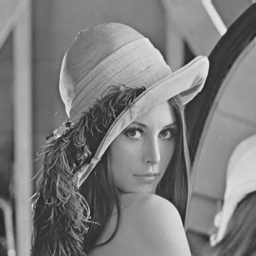

In [9]:
#随机选择一个元素，然后+1
def change_img(org_img_path, des_img_path):
    original_image = Image.open(org_img_path)
    original_array = np.array(original_image)

    # 随机选择一个元素的索引
    row = np.random.randint(0, original_array.shape[0])
    col = np.random.randint(0, original_array.shape[1])

    # 将选中的元素加1
    original_array[row, col] = (original_array[row, col] +1)%256

    des_img = Image.fromarray(original_array)
    des_img.save(des_img_path)

    return des_img

pimage = 'lena256.png'
original_path = 'misc/' + pimage
des_img_path = 'misc/df/' + 'change_' + pimage

change_img(original_path, des_img_path)



In [15]:
salt = "somesalt".encode()
key = np.random.randint(0, 256, size=32, dtype=np.uint8)

matrix = gen_key_matrix(key, salt)
matrix_sample = paddle.to_tensor(matrix,dtype = 'float32')
predicts = netG(matrix_sample)
#eval_out 就是加密的密钥流
key_streams = predicts.floor().numpy()
print(key_streams.shape)
print(key_streams)

pimage = 'lena256.png'
original_path = 'misc/' + pimage
encrypt_path1 = 'misc/df/' + "encrypt_image_"+pimage
decrypt_path1 = 'misc/df/' + "decrypt_image_"+pimage


encrypt(key_streams,original_path,encrypt_path1,decrypt_path1)


(256, 256)
[[ 89.  20.  96. ...  62. 169. 231.]
 [226. 174.   0. ... 121.  35. 167.]
 [ 18. 121.  20. ...  57. 223. 195.]
 ...
 [ 36.  68.  35. ... 113. 137. 186.]
 [ 48. 159. 155. ... 139.  54. 121.]
 [160.  52. 211. ...  26.   6.  20.]]
[[160 159 159 ... 168 169 143]
 [161 159 159 ... 169 171 146]
 [161 158 159 ... 157 149 118]
 ...
 [ 55  56  57 ...  85  96  96]
 [ 51  54  56 ...  95 104 103]
 [ 50  57  56 ... 103 106 110]]


In [16]:
salt = "somesalt2".encode()

matrix = gen_key_matrix(key, salt)
matrix_sample = paddle.to_tensor(matrix,dtype = 'float32')
predicts = netG(matrix_sample)
#eval_out 就是加密的密钥流
key_streams = predicts.floor().numpy()
print(key_streams.shape)
print(key_streams)

pimage = 'lena256.png'
original_path = 'misc/df/' + 'change_' + pimage
encrypt_path1 = 'misc/df/' + "change_encrypt_image_"+pimage
decrypt_path1 = 'misc/df/' + "change_decrypt_image_"+pimage


encrypt(key_streams,original_path,encrypt_path1,decrypt_path1)

(256, 256)
[[ 37.  77. 156. ...  58.   5. 101.]
 [  4. 183.  92. ...  50. 253.  79.]
 [ 50. 183.  26. ... 127. 162.   4.]
 ...
 [107. 253. 141. ... 238. 213. 231.]
 [  2. 226. 215. ... 157.   1.  42.]
 [190. 193. 236. ...  37.  88.  25.]]
[[160 159 159 ... 168 169 143]
 [161 159 159 ... 169 171 146]
 [161 158 159 ... 157 149 118]
 ...
 [ 55  56  57 ...  85  96  96]
 [ 51  54  56 ...  95 104 103]
 [ 50  57  56 ... 103 106 110]]


In [21]:
import cv2
import numpy as np

def calculate_npcr(original_image, encrypted_image):
    # 计算NPCR
    diff = original_image.astype(np.int16) - encrypted_image.astype(np.int16)
    num_changed_pixels = np.count_nonzero(diff)
    npc_rate = num_changed_pixels / (original_image.shape[0] * original_image.shape[1])
    return npc_rate

def calculate_uaci(original_image, encrypted_image):
    # 计算UACI
    diff = np.abs(original_image.astype(np.int16) - encrypted_image.astype(np.int16))
    uaci_value = np.mean(diff) / 255.
    return uaci_value


In [22]:
pimages = ['lena256','baboon256','boat256']

for i in range(len(pimages)):
    encrypt_path1 = 'misc/df/' + "encrypt_image_"+pimages[i] + '.png'
    encrypt_path2 = 'misc/df/' + "change_encrypt_image_"+pimages[i] + '.png'

    # 读取原始图片和加密后图片
    original_image = cv2.imread(encrypt_path1, cv2.IMREAD_GRAYSCALE)
    encrypted_image = cv2.imread(encrypt_path2, cv2.IMREAD_GRAYSCALE)
        
    # 计算NPCR和UACI
    npcr = calculate_npcr(original_image, encrypted_image)
    uaci = calculate_uaci(original_image, encrypted_image)

    # 输出NPCR和UACI
    print(pimages[i])
    print("NPCR:", npcr)
    print("UACI:", uaci)

lena256
NPCR: 0.9962921142578125
UACI: 0.33413163727405026
baboon256
NPCR: 0.99603271484375
UACI: 0.3332379509420956
boat256
NPCR: 0.995758056640625
UACI: 0.33504746380974265


Lena:
    NPCR: 0.9960784912109375
    UACI: 0.3355137245327819
    
 Baboon:
    NPCR: 0.996185302734375
    UACI: 0.33509030809589463
    
Boat:  
    NPCR: 0.99609375
    UACI: 0.3364233278760723